In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

import zipfile

import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics 
plt.style.use('ggplot')

In [380]:
import custom_funcs as cf

In [381]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Input data

Context

This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

The datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (If I am mistaken and the public license type disallowed me from doing so, I will take this down if requested.)

Content

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

Tips

What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'. This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value. Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

KNIME is a great tool (GUI) that can be used for this.
1 - File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.
2- File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad"
3- Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)
4- Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')
5- Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and
6- Partitioning Node test data split output to input Decision Tree predictor Node
7- Decision Tree learner Node output to input Decision Tree Node input
8- Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)
Inspiration

Use machine learning to determine which physiochemical properties make a wine 'good'!

Acknowledgements

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (I am mistaken and the public license type disallowed me from doing so, I will take this down at first request. I am not the owner of this dataset.

Please include this citation if you plan to use this database:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Relevant publication

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [13]:
!ls data

archive.zip           winequality-red.csv
bank-additional.zip   winequality-white.csv


In [18]:
df_red = pd.read_csv('./data/winequality-red.csv', sep=';')
display(df_red.head(3))
df_white = pd.read_csv('./data/winequality-white.csv', sep=';')
display(df_white.head(3))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [19]:
df_red.shape, df_white.shape

((1599, 12), (4898, 12))

In [30]:
df_red['color'] = 'r'
df_white['color'] = 'w'

In [31]:
df = pd.concat([df_red, df_white])

In [32]:
df.shape

(6497, 13)

In [33]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,r
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,r


# Exploratorial Analysis

In [35]:
for col in df.columns:
    print(f'Column: {col}. Has na columns: %s' % df[col].isna().any())

Column: fixed acidity. Has na columns: False
Column: volatile acidity. Has na columns: False
Column: citric acid. Has na columns: False
Column: residual sugar. Has na columns: False
Column: chlorides. Has na columns: False
Column: free sulfur dioxide. Has na columns: False
Column: total sulfur dioxide. Has na columns: False
Column: density. Has na columns: False
Column: pH. Has na columns: False
Column: sulphates. Has na columns: False
Column: alcohol. Has na columns: False
Column: quality. Has na columns: False
Column: color. Has na columns: False


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


In [38]:
display(df['quality'].value_counts().sort_index()) 
display(df['quality'].value_counts(normalize=True).sort_index())

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

3    0.004618
4    0.033246
5    0.329075
6    0.436509
7    0.166077
8    0.029706
9    0.000770
Name: quality, dtype: float64

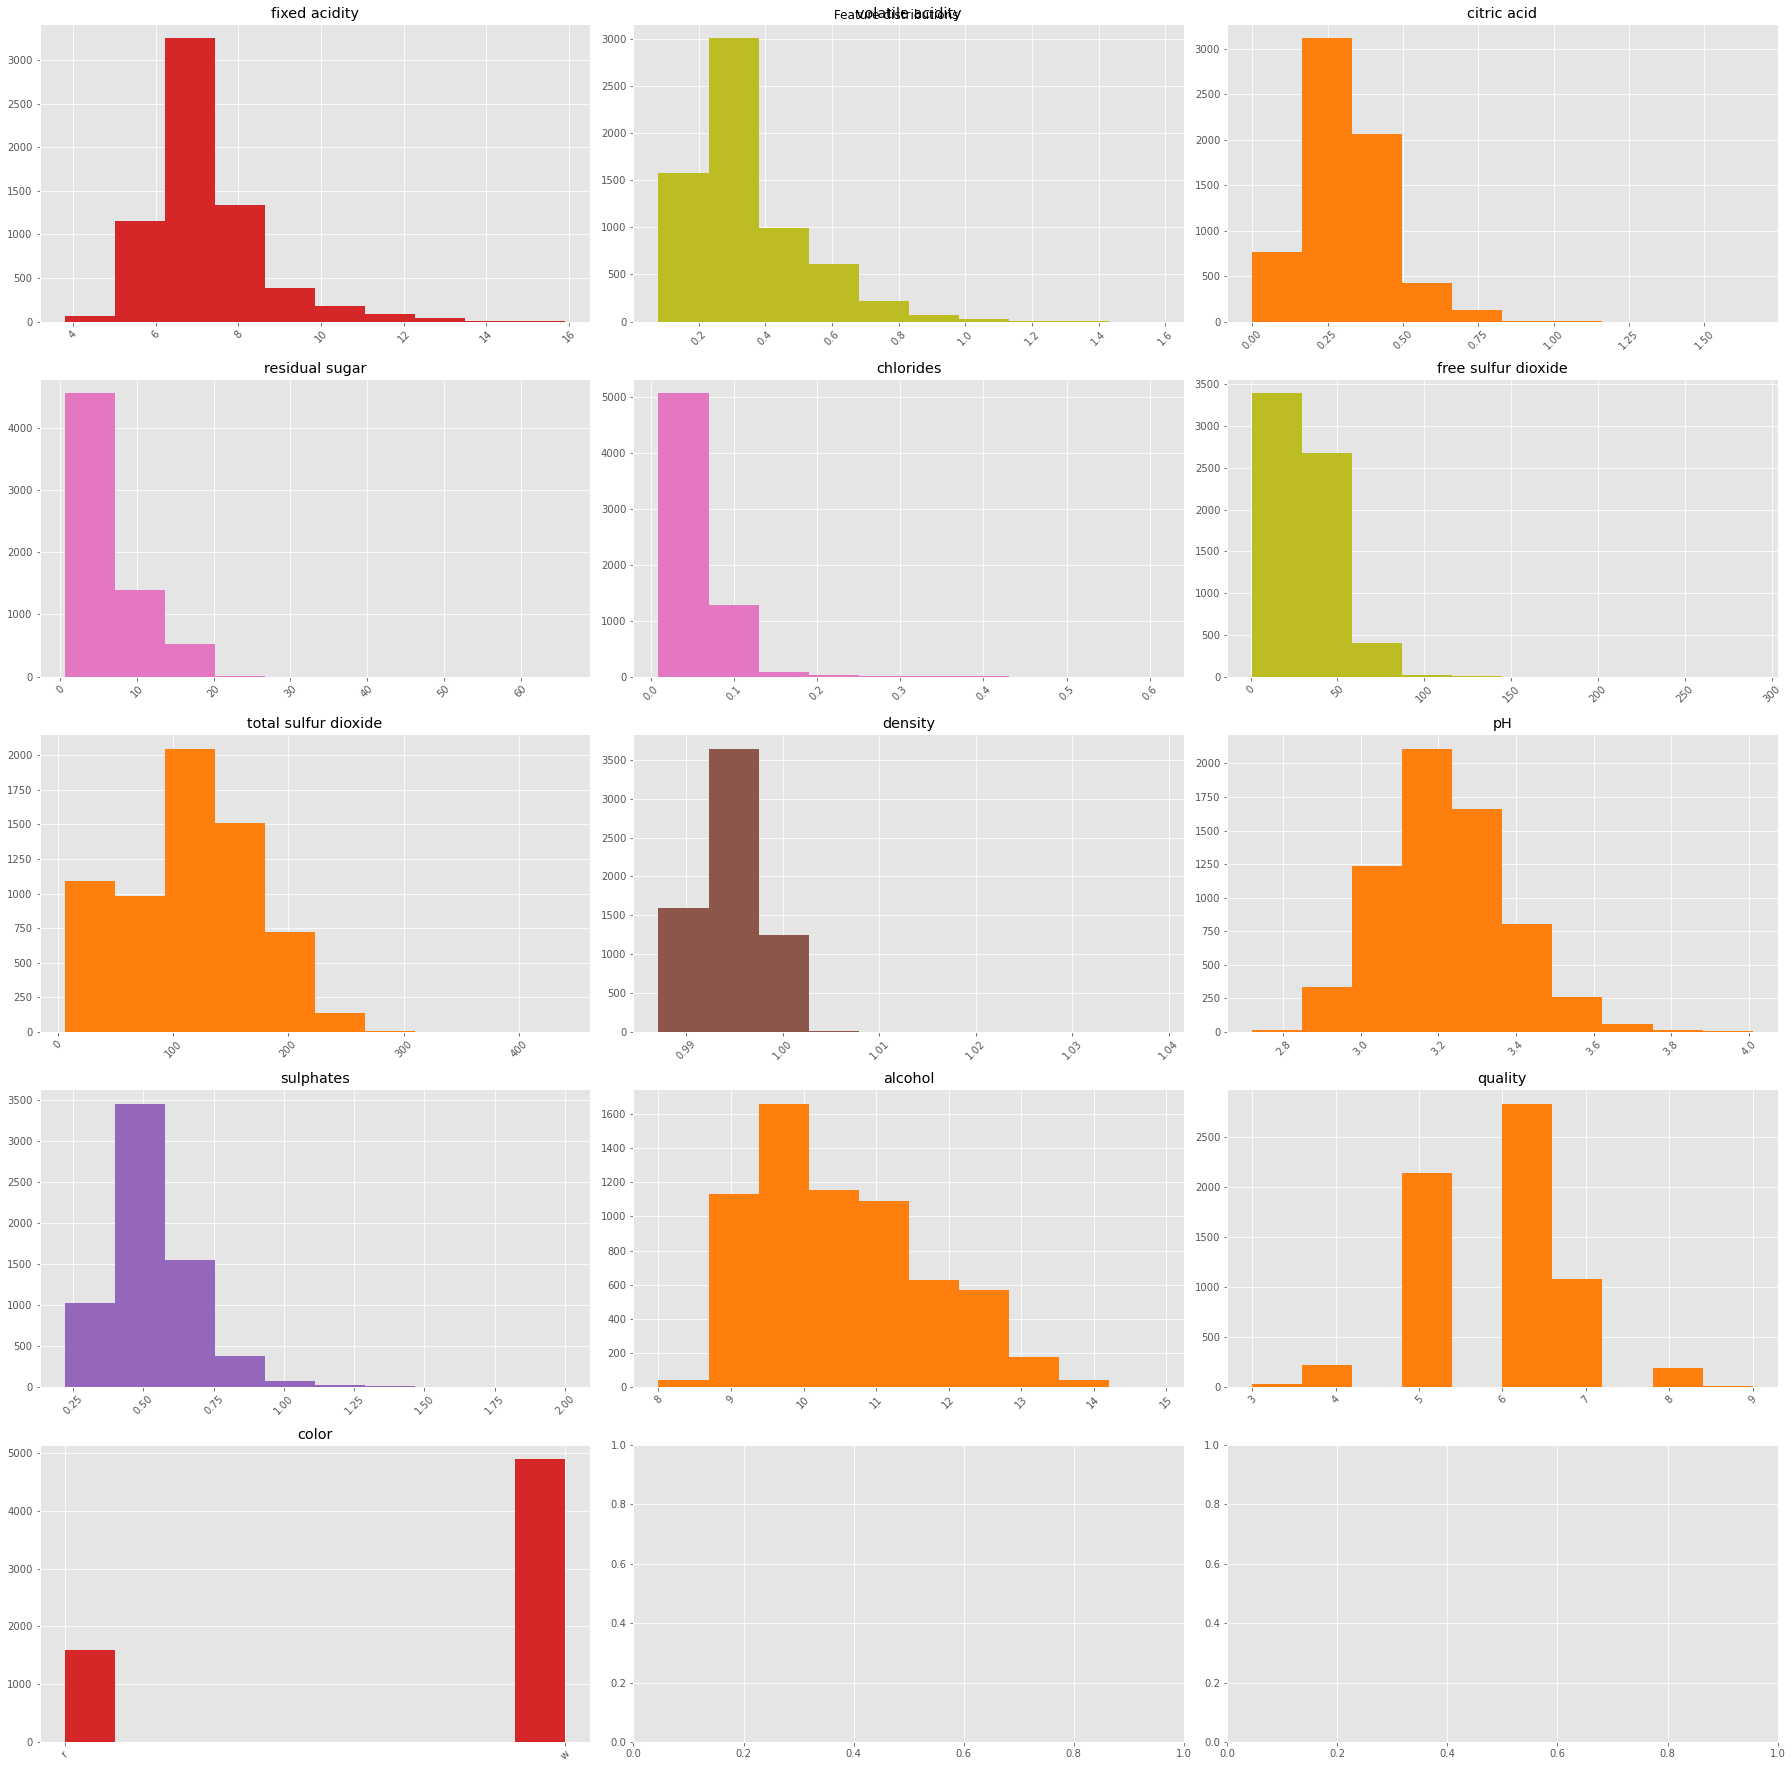

In [39]:
col_len = len(df.columns)
row_num = int(np.ceil(col_len/3))
colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan')

fig, axes = plt.subplots(row_num, 3)


fig.set_size_inches(25, row_num*5)

for num, col in enumerate(df.columns):
    cur_ax = axes[num//3][num%3]
    df[col].hist(ax=cur_ax, xrot=45, color=np.random.choice(colors))
    cur_ax.set_title(col)
    
plt.suptitle('Feature distributions')
plt.tight_layout()

In [40]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,r
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,r


## Conclusions

- The disribution of the feature values is close to normal or lognormal
- The distribution of the target label is also close to normal.

# Train, valid and test

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
train_X, test_X = train_test_split(df, train_size=0.9)

We will use 3 fold cross validation due to the fact that the dataset is not so big.

In [46]:
train_X.shape, test_X.shape

((4092, 13), (650, 13))

# Encoding

In [52]:
from sklearn.preprocessing import OneHotEncoder

As we have to explore a classification problem I should transform my label  
that has continious nature and ordered categories to pure categories.

It would be more interesting to divide wine into 3 categories according to the quality. 
It could be interpreted as:  
    - less than average  
    - average quality   
    - better than average  

In [57]:
df['quality_class'] = df['quality'].apply(lambda x: -1 if x < 5 else 1 if x > 6 else 0)

In [58]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,quality_class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,r,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,r,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,r,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,r,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,r,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,w,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,w,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,w,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,w,1


In [120]:
def encode_input_data(df, trained_ohes=None):
    df = df.copy()
    if not trained_ohes:
        trained_ohes = {}
    y = df['y'].values
#     y = df['y'].apply(lambda x: 1 if x == 'yes' else 0).values
    del df['y']
    
    encoded = []
    is_col_object = df.dtypes == 'object'
    for col, is_object in zip(df.dtypes.index, is_col_object):
        if not is_object:
            encoded.append(df[col].values.reshape(-1, 1))
        else:
            if col not in trained_ohes:
                ohe = OneHotEncoder(handle_unknown='ignore')
                trained_ohes[col] = ohe
                
            ohe_encoded = trained_ohes[col].fit_transform(df[col].values.reshape(-1, 1))
            encoded.append(ohe_encoded)
#         print(encoded[-1].shape)
#     X = np.hstack(encoded)
    X = sps.hstack(encoded)
    return X, y, trained_ohes

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
 13  quality_class         6497 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 761.4+ KB


In [121]:
X, y, trained_ohes = encode_input_data(
    df.rename(columns={'quality_class': 'y'}).drop(columns=['quality'])
)

In [102]:
trained_ohes

{'color': OneHotEncoder(handle_unknown='ignore')}

In [118]:
X.shape, y.shape

((6497, 13), (6497,))

In [122]:
pd.value_counts(y)

 0    4974
 1    1277
-1     246
dtype: int64

In [123]:
df.rename(columns={'quality_class': 'y'}).drop(columns=['quality'])['y'].value_counts()

 0    4974
 1    1277
-1     246
Name: y, dtype: int64

# Train, valid and test

In [240]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

In [125]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.9)

In [126]:
train_X.shape, train_y.shape

((5847, 13), (5847,))

In [127]:
test_y.shape, test_y.shape

((650,), (650,))

# Decision tree

In [129]:
from sklearn.tree import DecisionTreeClassifier

## Let's look at train ammount  score

### Here I will have to use validation dataset

In [325]:
flex_train_X, valid_X, flex_train_y, valid_y = train_test_split(train_X, train_y, train_size=0.9)

In [326]:
flex_train_X.shape, valid_X.shape, flex_train_y.shape, valid_y.shape

((5262, 13), (585, 13), (5262,), (585,))

In [ ]:
# 6

In [330]:
np.random.seed(13)
metrics_dict = {}

dt_clf = DecisionTreeClassifier(max_depth=6, random_state=13, criterion='entropy')

for i in range(10, 110, 10):
    random_index = np.random.choice(flex_train_X.shape[0], 
                                    replace=False,
                                    size=min(flex_train_X.shape[0], round(flex_train_X.shape[0] * i/100)))
    
    
    
    _, duration = cf.time_it(dt_clf.fit, flex_train_X[random_index], flex_train_y[random_index])
    preds = dt_clf.predict(valid_X)
    
    metrics = []
    
    metrics.append(sklearn.metrics.accuracy_score(valid_y, preds))
    cl_precision = []
    
    for cl in sorted(np.unique(valid_y)):
        
        cl_precision.append(
            sklearn.metrics.precision_score(
                np.where(valid_y == cl, 1, 0), np.where(preds == cl, 1, 0)
            )
        )
    
    cl_recall = []
    
    for cl in sorted(np.unique(valid_y)):
        
        cl_recall.append(
            sklearn.metrics.recall_score(
                np.where(valid_y == cl, 1, 0), np.where(preds == cl, 1, 0)
            )
        )
    
    metrics.append(duration)
    metrics.append(cl_precision)
    metrics.append(cl_recall)
    
    
    metrics_dict[i] = metrics
    print(f"{i}% Ammount: {random_index.shape[0]} {duration:.4f} seconds, accuracy: {metrics[0]:.4f}")

10% Ammount: 526 0.0038 seconds, accuracy: 0.7385
20% Ammount: 1052 0.0066 seconds, accuracy: 0.7521
30% Ammount: 1579 0.0099 seconds, accuracy: 0.7521
40% Ammount: 2105 0.0126 seconds, accuracy: 0.7624
50% Ammount: 2631 0.0149 seconds, accuracy: 0.7556
60% Ammount: 3157 0.0174 seconds, accuracy: 0.7675
70% Ammount: 3683 0.0212 seconds, accuracy: 0.7573
80% Ammount: 4210 0.0239 seconds, accuracy: 0.7709
90% Ammount: 4736 0.0259 seconds, accuracy: 0.7538
100% Ammount: 5262 0.0282 seconds, accuracy: 0.7658


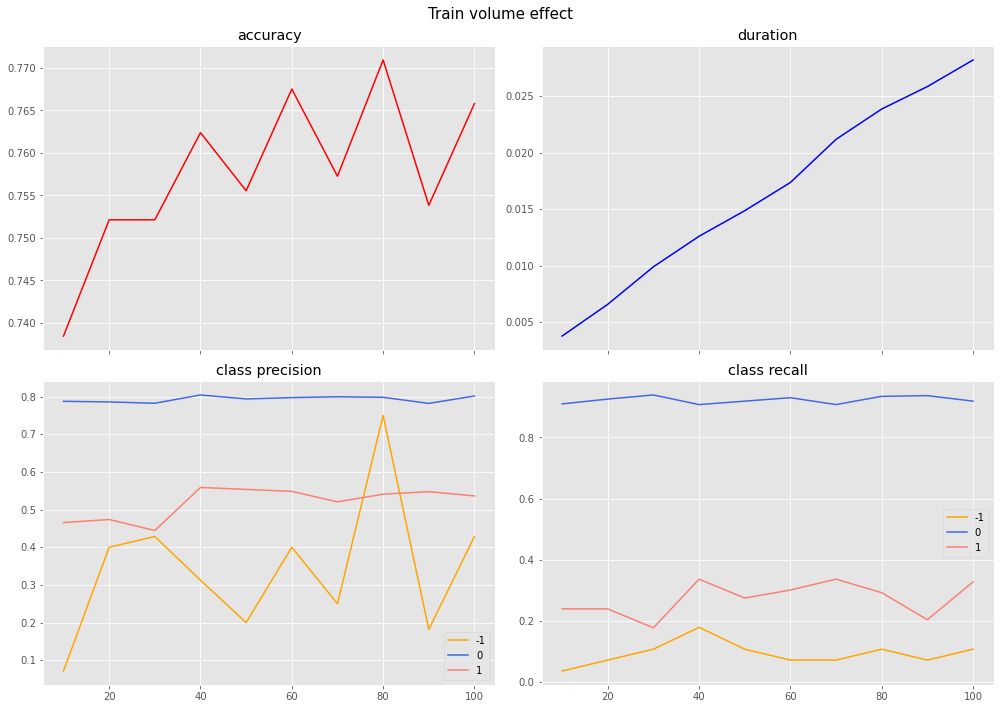

In [331]:
perc = sorted(metrics_dict.keys())
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(14, 10)

axes[0][0].plot(perc,
             [metrics_dict[x][0] for x in perc], color='red')
axes[0][0].set_title('accuracy')

axes[0][1].plot(perc,
            [metrics_dict[x][1] for x in perc], color='blue')
axes[0][1].set_title('duration')

colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i in range(3):
    axes[1][0].plot(perc,
                [metrics_dict[x][2][i] for x in perc],
                 color=colors[i], label=class_names[i])
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i in range(3):
    axes[1][1].plot(perc,
                [metrics_dict[x][3][i] for x in perc],
                 color=colors[i], label=class_names[i])
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Train volume effect', fontsize=15)
plt.tight_layout();

In [ ]:
# 20

In [339]:
np.random.seed(13)
metrics_dict = {}

dt_clf = DecisionTreeClassifier(max_depth=20, random_state=13, criterion='entropy')

for i in range(10, 110, 10):
    random_index = np.random.choice(flex_train_X.shape[0], 
                                    replace=False,
                                    size=min(flex_train_X.shape[0], round(flex_train_X.shape[0] * i/100)))
    
    
    
    _, duration = cf.time_it(dt_clf.fit, flex_train_X[random_index], flex_train_y[random_index])
    preds = dt_clf.predict(valid_X)
    
    metrics = []
    
    metrics.append(sklearn.metrics.accuracy_score(valid_y, preds))
    cl_precision = []
    
    for cl in sorted(np.unique(valid_y)):
        
        cl_precision.append(
            sklearn.metrics.precision_score(
                np.where(valid_y == cl, 1, 0), np.where(preds == cl, 1, 0)
            )
        )
    
    cl_recall = []
    
    for cl in sorted(np.unique(valid_y)):
        
        cl_recall.append(
            sklearn.metrics.recall_score(
                np.where(valid_y == cl, 1, 0), np.where(preds == cl, 1, 0)
            )
        )
    
    metrics.append(duration)
    metrics.append(cl_precision)
    metrics.append(cl_recall)
    
    
    metrics_dict[i] = metrics
    print(f"{i}% Ammount: {random_index.shape[0]} {duration:.4f} seconds, accuracy: {metrics[0]:.4f}")

10% Ammount: 526 0.0073 seconds, accuracy: 0.6940
20% Ammount: 1052 0.0115 seconds, accuracy: 0.7299
30% Ammount: 1579 0.0187 seconds, accuracy: 0.7419
40% Ammount: 2105 0.0283 seconds, accuracy: 0.7453
50% Ammount: 2631 0.0333 seconds, accuracy: 0.7521
60% Ammount: 3157 0.0484 seconds, accuracy: 0.7641
70% Ammount: 3683 0.0665 seconds, accuracy: 0.7761
80% Ammount: 4210 0.0798 seconds, accuracy: 0.7897
90% Ammount: 4736 0.0869 seconds, accuracy: 0.7829
100% Ammount: 5262 0.0951 seconds, accuracy: 0.7949


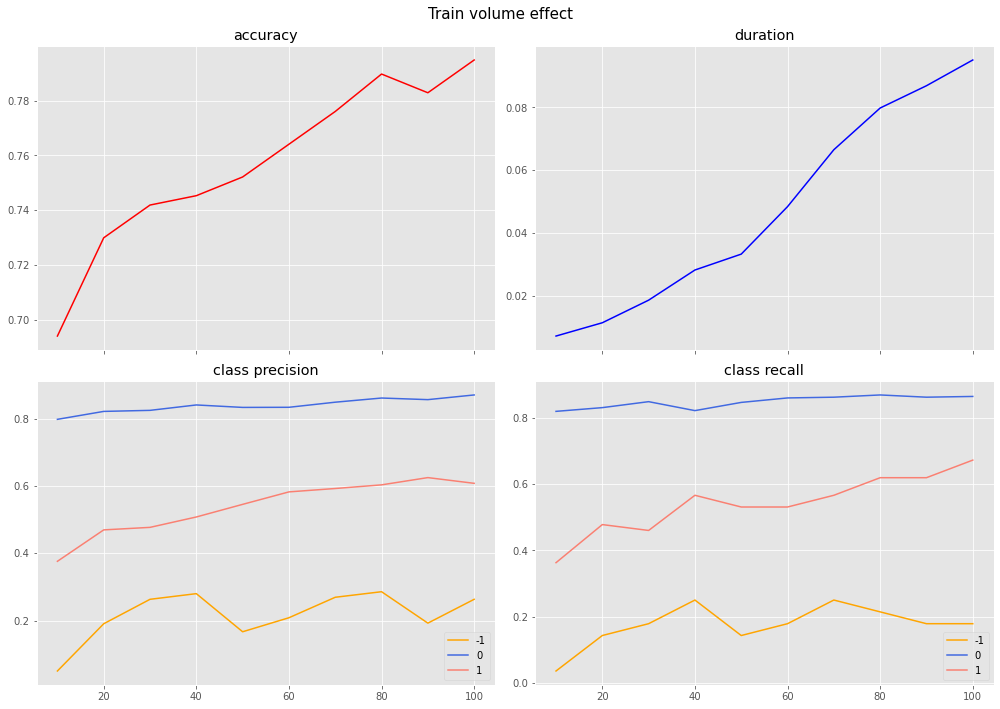

In [340]:
perc = sorted(metrics_dict.keys())
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(14, 10)

axes[0][0].plot(perc,
             [metrics_dict[x][0] for x in perc], color='red')
axes[0][0].set_title('accuracy')

axes[0][1].plot(perc,
            [metrics_dict[x][1] for x in perc], color='blue')
axes[0][1].set_title('duration')

colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i in range(3):
    axes[1][0].plot(perc,
                [metrics_dict[x][2][i] for x in perc],
                 color=colors[i], label=class_names[i])
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i in range(3):
    axes[1][1].plot(perc,
                [metrics_dict[x][3][i] for x in perc],
                 color=colors[i], label=class_names[i])
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Train volume effect', fontsize=15)
plt.tight_layout();

In [ ]:
# Conclusion - the more data we have the better score we have on the valid set

## The model flexibility

## Gini

In [238]:
def custom_scorer(estimator, X, y):
    preds = estimator.predict(X)
    
    metrics = {}
    
    metrics['accuracy'] = sklearn.metrics.accuracy_score(y, preds)
    
    for cl in sorted(np.unique(y)):
        metrics[f'precision_{cl}'] = sklearn.metrics.precision_score(
                np.where(y == cl, 1, 0), np.where(preds == cl, 1, 0)
        )
        
    for cl in sorted(np.unique(y)):
        metrics[f'recall_{cl}'] = sklearn.metrics.recall_score(
                np.where(y == cl, 1, 0), np.where(preds == cl, 1, 0)
        )
    
    return metrics


In [243]:
def custom_scorer_factory(f, cl):
    def custom_metric(estimator, X, y):
        preds = estimator.predict(X)
        return f(np.where(y == cl, 1, 0),
                np.where(preds == cl, 1, 0))
    return custom_metric

In [301]:
np.random.seed(13)
metrics_dict = {}

scorer_dict = {
    f"precision_{cl}": custom_scorer_factory(sklearn.metrics.precision_score, cl)
    for cl in sorted(np.unique(y))
}

scorer_dict.update({
    f"recall_{cl}": custom_scorer_factory(sklearn.metrics.recall_score, cl)
    for cl in sorted(np.unique(y))
})

scorer_dict['accuracy'] = lambda estimator, X, y: sklearn.metrics.accuracy_score(y, estimator.predict(X))
metrics = {}

for max_depth in range(2, 50, 2):
    dt_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=13, criterion='gini')
    
    metrics[max_depth] = cross_validate(dt_clf, X=train_X, y=train_y, cv=3, n_jobs=1, scoring=scorer_dict)

/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [302]:
metrics2 = dict(
    map(lambda x: (x[0],
                   dict(map(lambda y: (y[0], np.mean(y[1]).round(4)), x[1].items()))),
        metrics.items())
)

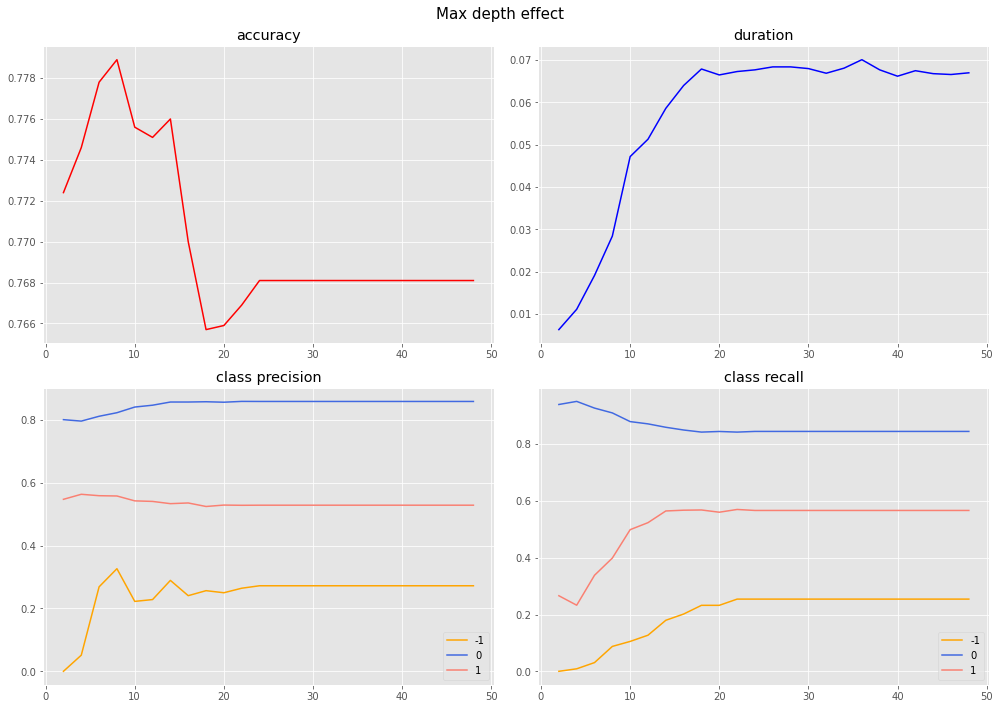

In [305]:
perc = sorted(metrics_dict.keys())
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

x_values = sorted(metrics2.keys())

axes[0][0].plot(x_values,
                [metrics2[x]['test_accuracy'] for x in x_values], color='red')
axes[0][0].set_title('accuracy')


axes[0][1].plot(x_values,
                [metrics2[x]['fit_time'] for x in x_values], color='blue')
axes[0][1].set_title('duration')


colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i, cl in enumerate(class_names):
    axes[1][0].plot(x_values,
                    [metrics2[x][f'test_precision_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i, cl in enumerate(class_names):
    axes[1][1].plot(x_values,
                    [metrics2[x][f'test_recall_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Max depth effect', fontsize=15)
plt.tight_layout();

In [395]:
md_metrics = \
    cf.brute_force_parameters(par_name='max_depth',
                              par_values=range(2, 50, 2),
                              estimator_kwargs={'random_state': 13, 'criterion': 'gini'},
                              X_train=train_X, y_train=train_y)

/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


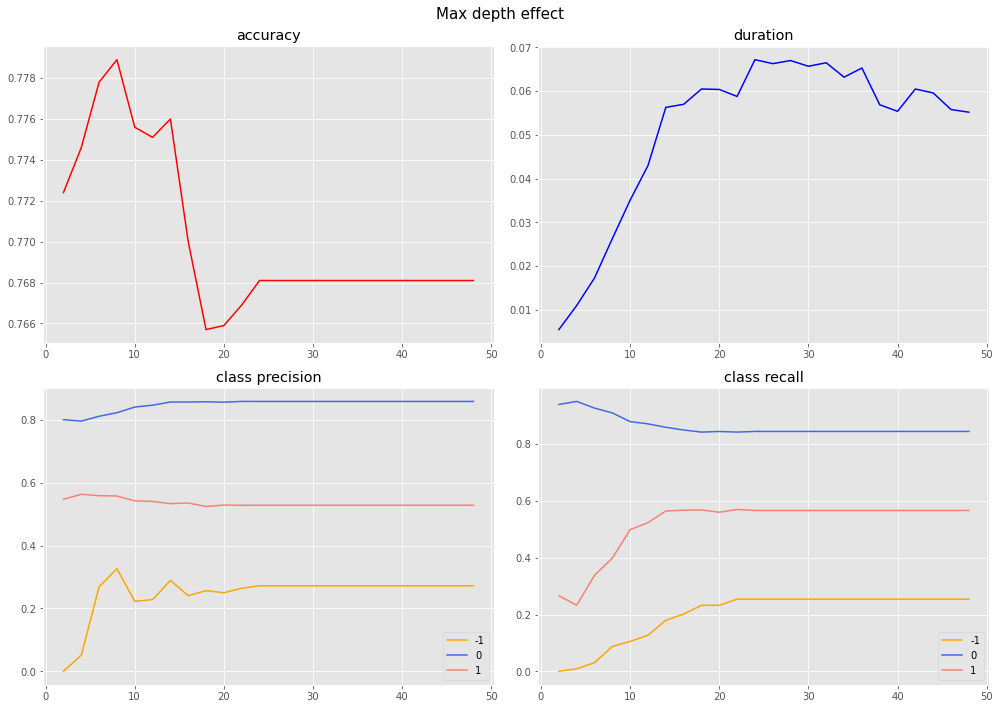

In [396]:
fig, axes = cf.plot_metrics(md_metrics, sorted(pd.unique(train_y).tolist()))

In [323]:
metrics2

{2: {'fit_time': 0.0078,
  'score_time': 0.009,
  'test_precision_-1': 0.0,
  'test_precision_0': 0.7839,
  'test_precision_1': 0.1601,
  'test_recall_-1': 0.0,
  'test_recall_0': 0.9627,
  'test_recall_1': 0.139,
  'test_accuracy': 0.7648},
 4: {'fit_time': 0.012,
  'score_time': 0.0079,
  'test_precision_-1': 0.125,
  'test_precision_0': 0.7922,
  'test_precision_1': 0.5831,
  'test_recall_-1': 0.0132,
  'test_recall_0': 0.9603,
  'test_recall_1': 0.2031,
  'test_accuracy': 0.776},
 6: {'fit_time': 0.0222,
  'score_time': 0.0081,
  'test_precision_-1': 0.5568,
  'test_precision_0': 0.8075,
  'test_precision_1': 0.5925,
  'test_recall_-1': 0.0702,
  'test_recall_0': 0.9476,
  'test_recall_1': 0.29,
  'test_accuracy': 0.7854},
 8: {'fit_time': 0.0372,
  'score_time': 0.0086,
  'test_precision_-1': 0.2751,
  'test_precision_0': 0.8297,
  'test_precision_1': 0.5228,
  'test_recall_-1': 0.1272,
  'test_recall_0': 0.8815,
  'test_recall_1': 0.4456,
  'test_accuracy': 0.7672},
 10: {'fit_ti

## Entropy gain 

In [310]:
np.random.seed(13)
metrics_dict = {}

scorer_dict = {
    f"precision_{cl}": custom_scorer_factory(sklearn.metrics.precision_score, cl)
    for cl in sorted(np.unique(y))
}

scorer_dict.update({
    f"recall_{cl}": custom_scorer_factory(sklearn.metrics.recall_score, cl)
    for cl in sorted(np.unique(y))
})

scorer_dict['accuracy'] = lambda estimator, X, y: sklearn.metrics.accuracy_score(y, estimator.predict(X))
metrics = {}

for max_depth in range(2, 50, 2):
    dt_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=13, criterion='entropy')
    
    metrics[max_depth] = cross_validate(dt_clf, X=train_X, y=train_y, cv=3, n_jobs=1, scoring=scorer_dict)

/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classi

In [311]:
metrics2 = dict(
    map(lambda x: (x[0],
                   dict(map(lambda y: (y[0], np.mean(y[1]).round(4)), x[1].items()))),
        metrics.items())
)

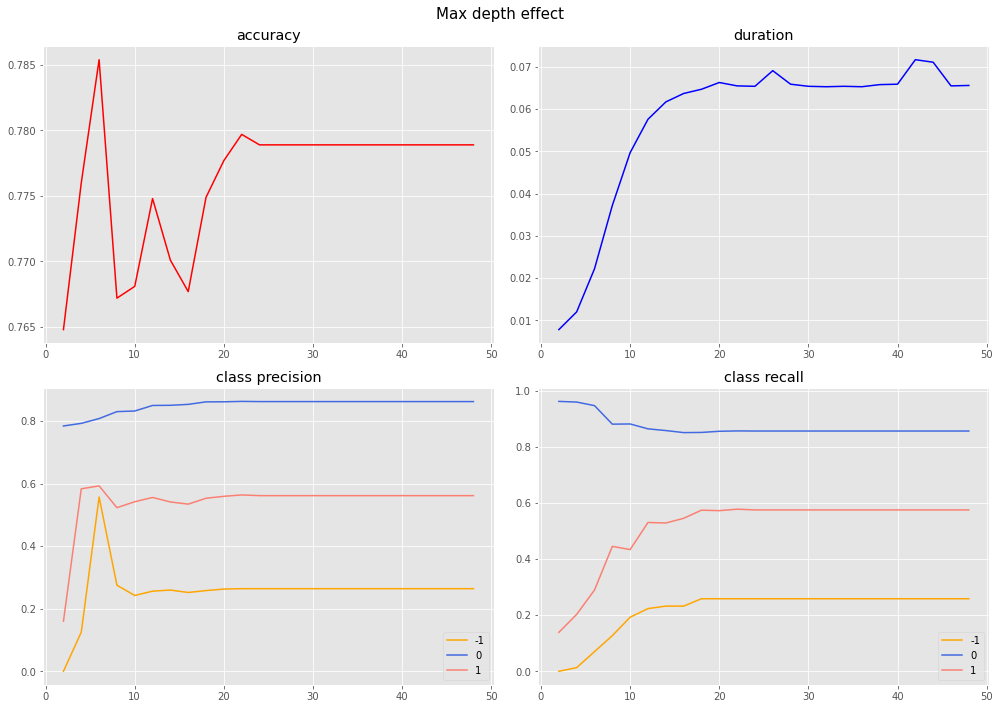

In [312]:
perc = sorted(metrics_dict.keys())
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

x_values = sorted(metrics2.keys())

axes[0][0].plot(x_values,
                [metrics2[x]['test_accuracy'] for x in x_values], color='red')
axes[0][0].set_title('accuracy')


axes[0][1].plot(x_values,
                [metrics2[x]['fit_time'] for x in x_values], color='blue')
axes[0][1].set_title('duration')


colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i, cl in enumerate(class_names):
    axes[1][0].plot(x_values,
                    [metrics2[x][f'test_precision_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i, cl in enumerate(class_names):
    axes[1][1].plot(x_values,
                    [metrics2[x][f'test_recall_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Max depth effect', fontsize=15)
plt.tight_layout();

## Get rid of imbalance

In [373]:
np.random.seed(13)
metrics_dict = {}

scorer_dict = {
    f"precision_{cl}": custom_scorer_factory(sklearn.metrics.precision_score, cl)
    for cl in sorted(np.unique(y))
}

scorer_dict.update({
    f"recall_{cl}": custom_scorer_factory(sklearn.metrics.recall_score, cl)
    for cl in sorted(np.unique(y))
})

scorer_dict['accuracy'] = lambda estimator, X, y: sklearn.metrics.accuracy_score(y, estimator.predict(X))
metrics = {}

for max_depth in range(2, 50, 2):
    dt_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=13, criterion='entropy', class_weight='balanced')
    
    metrics[max_depth] = cross_validate(dt_clf, X=train_X, y=train_y, cv=3, n_jobs=1, scoring=scorer_dict)

In [374]:
metrics2 = dict(
    map(lambda x: (x[0],
                   dict(map(lambda y: (y[0], np.mean(y[1]).round(4)), x[1].items()))),
        metrics2.items())
)

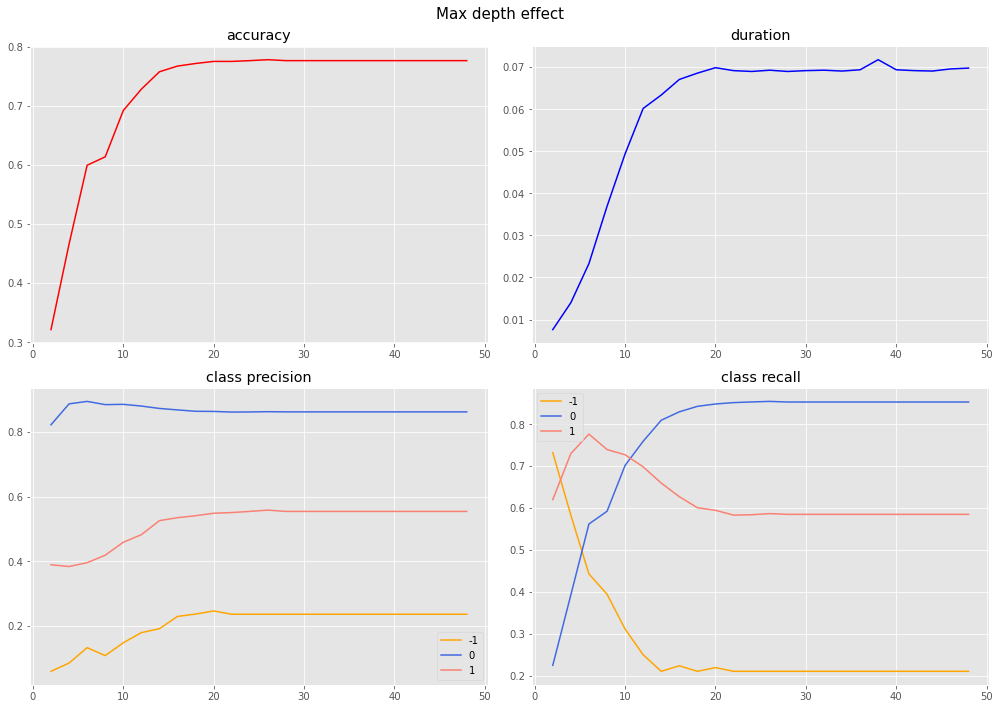

In [376]:

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

x_values = sorted(metrics2.keys())

axes[0][0].plot(x_values,
                [metrics2[x]['test_accuracy'] for x in x_values], color='red')
axes[0][0].set_title('accuracy')


axes[0][1].plot(x_values,
                [metrics2[x]['fit_time'] for x in x_values], color='blue')
axes[0][1].set_title('duration')


colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i, cl in enumerate(class_names):
    axes[1][0].plot(x_values,
                    [metrics2[x][f'test_precision_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i, cl in enumerate(class_names):
    axes[1][1].plot(x_values,
                    [metrics2[x][f'test_recall_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Max depth effect', fontsize=15)
plt.tight_layout();

# Pruning

In [341]:
dt_clf = DecisionTreeClassifier(max_depth=20, random_state=13, criterion='entropy')

In [359]:
ccp_alphas, impurities = [
    dt_clf.cost_complexity_pruning_path(train_X, train_y)[x] for x in ['ccp_alphas', 'impurities']]

In [377]:
np.random.seed(13)
metrics_dict = {}

scorer_dict = {
    f"precision_{cl}": custom_scorer_factory(sklearn.metrics.precision_score, cl)
    for cl in sorted(np.unique(y))
}

scorer_dict.update({
    f"recall_{cl}": custom_scorer_factory(sklearn.metrics.recall_score, cl)
    for cl in sorted(np.unique(y))
})

scorer_dict['accuracy'] = lambda estimator, X, y: sklearn.metrics.accuracy_score(y, estimator.predict(X))
metrics = {}

for ccp_alpha in ccp_alphas:
    dt_clf = DecisionTreeClassifier(random_state=13, criterion='entropy', ccp_alpha=ccp_alpha, max_depth=30)
    metrics[ccp_alpha] = cross_validate(dt_clf, X=train_X, y=train_y, cv=3, n_jobs=1, scoring=scorer_dict)

/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classi

/opt/miniconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [378]:
metrics = dict(
    map(lambda x: (x[0],
                   dict(map(lambda y: (y[0], np.mean(y[1]).round(4)), x[1].items()))),
        metrics.items())
)

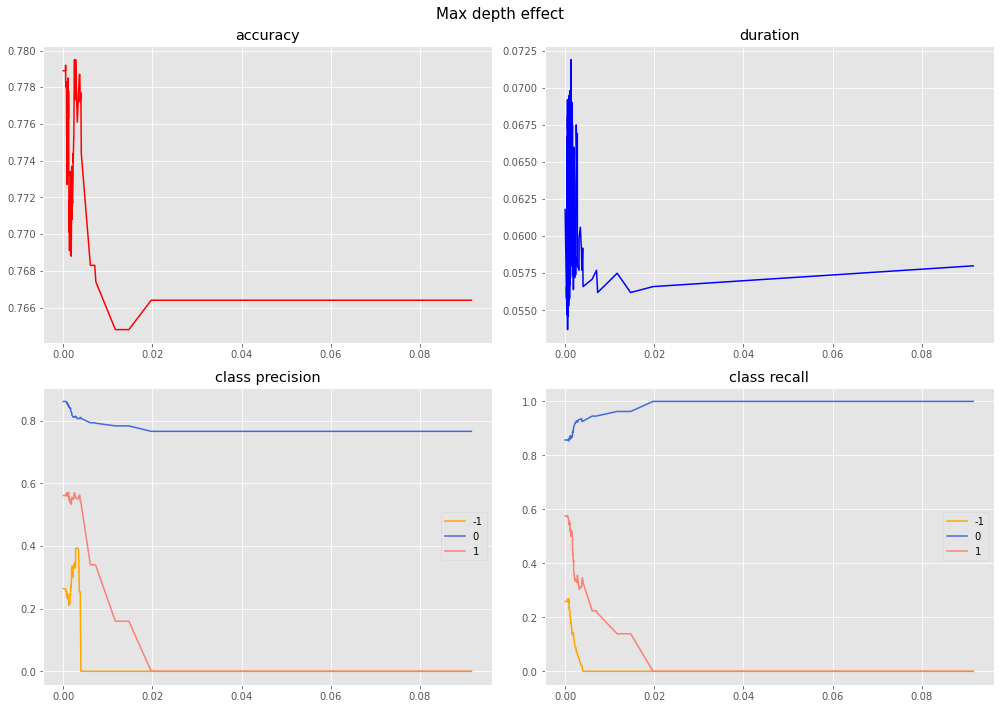

In [379]:

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

x_values = sorted(metrics.keys())

axes[0][0].plot(x_values,
                [metrics[x]['test_accuracy'] for x in x_values], color='red')
axes[0][0].set_title('accuracy')


axes[0][1].plot(x_values,
                [metrics[x]['fit_time'] for x in x_values], color='blue')
axes[0][1].set_title('duration')


colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i, cl in enumerate(class_names):
    axes[1][0].plot(x_values,
                    [metrics[x][f'test_precision_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i, cl in enumerate(class_names):
    axes[1][1].plot(x_values,
                    [metrics[x][f'test_recall_{cl}'] for x in x_values],
                    color=colors[i], label=class_names[i])
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Max depth effect', fontsize=15)
plt.tight_layout();

Text(0.5, 1.0, 'Prunning effect')

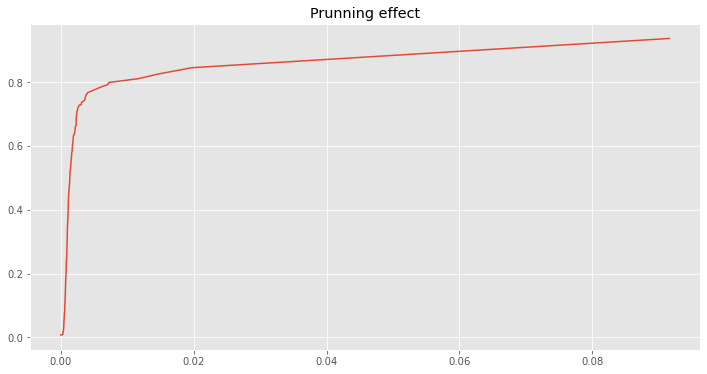

In [350]:
plt.figure(figsize=(12, 6))
plt.plot(path.ccp_alphas, path.impurities)

plt.title('Prunning effect');

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

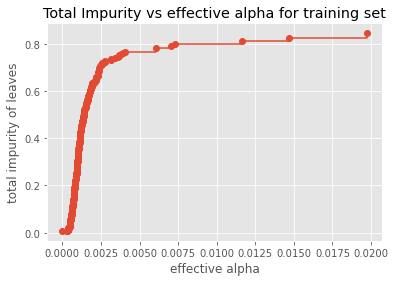

In [346]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [290]:
int(duration)

0

In [198]:
dt_clf.fit(train_X, train_y)

DecisionTreeClassifier()

In [243]:
preds = dt_clf.predict(valid_X)

In [202]:
print(sklearn.metrics.classification_report(valid_y, preds))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      9855
           1       0.50      0.52      0.51      1266

    accuracy                           0.89     11121
   macro avg       0.72      0.73      0.72     11121
weighted avg       0.89      0.89      0.89     11121



In [244]:
sklearn.metrics.accuracy_score(valid_y, preds)

0.88634115637083

In [245]:
sklearn.metrics.roc_auc_score(valid_y, preds)

0.7276236471490641

In [204]:
sklearn.metrics.accuracy_score(valid_y, np.zeros(valid_y.shape))

0.8861613164283787

# NN

In [205]:
from sklearn.neural_network import MLPClassifier

In [230]:
nn_clf = MLPClassifier((10, 0), learning_rate='adaptive')

In [238]:
for i in np.arange(10, 50, 10):
    nn_clf = MLPClassifier((i, ), learning_rate='adaptive')
    nn_clf.fit(train_X, train_y)
    nn_preds = nn_clf.predict(valid_X)
    print(i, sklearn.metrics.accuracy_score(valid_y, nn_preds))

10 0.9009981116806043
20 0.8995593921409946
30 0.9017174714504091
40 0.904055390702275


In [240]:
for i in np.arange(10, 50, 10):
    for j in np.arange(10, 50, 10):
        nn_clf = MLPClassifier((i, j), learning_rate='adaptive')
        nn_clf.fit(train_X, train_y)
        nn_preds = nn_clf.predict(valid_X)
        print((i, j), sklearn.metrics.accuracy_score(valid_y, nn_preds), )

(10, 10) 0.9048646704433054
(10, 20) 0.8999190720258969
(10, 30) 0.9022569912777628
(10, 40) 0.8939843539250067
(20, 10) 0.9022569912777628
(20, 20) 0.908191709378653
(20, 30) 0.8379642118514522
(20, 40) 0.9072025896951713
(30, 10) 0.9052243503282079
(30, 20) 0.8616131642837874
(30, 30) 0.8930851542127507
(30, 40) 0.9044150705871774
(40, 10) 0.9058537901267871
(40, 20) 0.8940742738962324
(40, 30) 0.8929053142702994
(40, 40) 0.8915565147019153


In [249]:
for j in np.arange(10, 100, 25):
    for k in np.arange(10, 100, 25):
        nn_clf = MLPClassifier((100, j, k), learning_rate='adaptive')
        nn_clf.fit(train_X, train_y)
        nn_preds = nn_clf.predict(valid_X)
        print((i, j, k), "%.3f, %.3f" % (
            sklearn.metrics.accuracy_score(valid_y, nn_preds), sklearn.metrics.roc_auc_score(valid_y, nn_preds)))

(85, 10, 10) 0.901, 0.800
(85, 10, 35) 0.905, 0.792
(85, 10, 60) 0.907, 0.690
(85, 10, 85) 0.903, 0.624
(85, 35, 10) 0.899, 0.782
(85, 35, 35) 0.891, 0.542
(85, 35, 60) 0.900, 0.797
(85, 35, 85) 0.901, 0.802
(85, 60, 10) 0.899, 0.582
(85, 60, 35) 0.901, 0.606
(85, 60, 60) 0.904, 0.787
(85, 60, 85) 0.899, 0.595
(85, 85, 10) 0.886, 0.500
(85, 85, 35) 0.909, 0.757
(85, 85, 60) 0.906, 0.722
(85, 85, 85) 0.887, 0.842


In [223]:
nn_preds = nn_clf.predict(valid_X)

In [224]:
sklearn.metrics.accuracy_score(valid_y, nn_preds)

0.8979408326589335

In [ ]:
0.9032461109612445 - 100, 100

In [ ]:
0.9110691484578725 - 50, 10